# Overview

In this notebook, I will be working with the ViT model for image classification using the CIFAR10 dataset. 

It involves going through the full machine learning lifecycle, including: preprocessing and exploratory data analysis, model implementation and training, tuning, and evaluation. 

In [1]:
import torch
import pandas as pd
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models.vision_transformer import Encoder
import matplotlib.pyplot as plt

# Data Loading

In [2]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10('./', train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.CIFAR10('./', train=False, download=True, transform=test_transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Image shape:  torch.Size([3, 32, 32])
   9:truck     2:bird     8:ship     5: dog


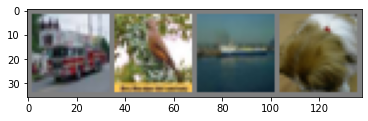

In [3]:
classes = train_dataset.classes
batch_size = 16
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # plt accepts images in the format (w,h,c)
    
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)


print(f"Classes: {classes}")
print("Image shape: ", images[0].shape)
# show images
imshow(torchvision.utils.make_grid(images[:4]))

# print labels
print('  '.join('  %2d:%4s' % (labels[j], classes[labels[j]]) for j in range(4)))

## A bit of exploratory data analysis (EDA)

EDA for CIFAR10: 
 # Train samples: 50000
 # Test samples: 10000
 Classes: {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
 # Samples for Class 0: 5000
 # Samples for Class 1: 5000
 # Samples for Class 2: 5000
 # Samples for Class 3: 5000
 # Samples for Class 4: 5000
 # Samples for Class 5: 5000
 # Samples for Class 6: 5000
 # Samples for Class 7: 5000
 # Samples for Class 8: 5000
 # Samples for Class 9: 5000


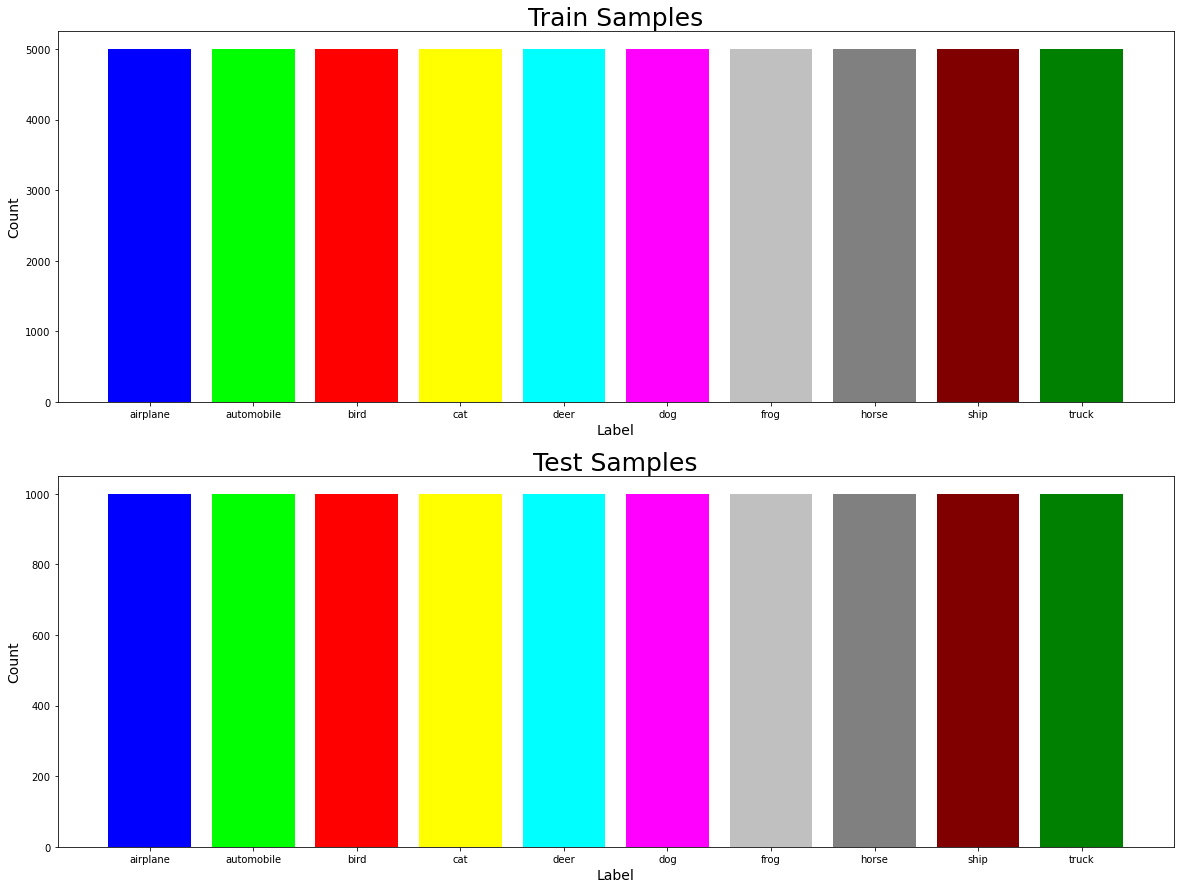

In [4]:
#############################################################################
# Let's figure out the size of the dataset:                                 #
# How many samples in train/test?                                           #
# How many labels? How many samples per label?                              #
# also we can try access train_dataset.__dict__.keys() to see which         #
# attributes are available on train_dataset.                                #
#############################################################################

n_train = len(train_dataset)
n_test = len(test_dataset)
labels = np.unique(train_dataset.targets)
n_labels = len(labels)
n_samples_per_idx = []

for label in labels:
    indices = [idx for idx, target in enumerate(train_dataset.targets) if target==label]
    n_samples_per_idx.append(len(train_dataset.data[indices]))
    
print("EDA for CIFAR10: ")
print(f" # Train samples: {n_train}")
print(f" # Test samples: {n_test}")
print(f" Classes: {train_dataset.class_to_idx}")
for i, x in enumerate(n_samples_per_idx):
    print(f" # Samples for Class {i}: {x}")
    
fig, ax = plt.subplots(2, 1, figsize=(20,15))

train_labels = [label for data, label in train_dataset]
tr_labels, tr_counts = np.unique(train_labels, return_counts=True)
colors = ["#0000FF", "#00FF00", "#FF0000", "#FFFF00", "#00FFFF", "#FF00FF", "#C0C0C0", "#808080", "#800000", "#008000"]
ax[0].bar(train_dataset.classes, tr_counts, color=colors)
ax[0].set_xlabel('Label', fontsize="14")
ax[0].set_ylabel('Count', fontsize="14")
ax[0].set_title('Train Samples',fontsize="25")

test_labels = [label for data, label in test_dataset]
te_labels, te_counts = np.unique(test_labels, return_counts=True)
ax[1].bar(test_dataset.classes, te_counts, color=colors)
ax[1].set_xlabel('Label', fontsize="14")
ax[1].set_ylabel('Count', fontsize="14")
ax[1].set_title('Test Samples',fontsize="25")

plt.show()

## Create DataLoaders

In [5]:
batch_size = 32
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Building a ViT Model

In the next section, we will construct a Vision Transformer, a transformer-based image classifier. The goal of the ViT model is to bring advancements from the natural language processing field to computer vision. 

For this part, we will implement the ViT model using a pre-built Encoder from the PyTorch library. If you are not familiar with the ViT model, it is highly recommended that you gain an understanding of its workings. There is a ton of information available online, here is a pretty informative source:
https://www.kaggle.com/code/abhinand05/vision-transformer-vit-tutorial-baseline

### Note
When implementing a ViT model it is possible to use token's for different objectives, since we have one objective (image classification) this isn't needed.
The classification token is an additional concatinated patch that is piped into the encoder. This is a learnable parametric token on wich the classification is done after the encoder. I implemented both architectures, not using the token seemed to yeild better results so thats what is implemented.

In [6]:
class ViT(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, num_layers, num_heads, hidden_dim, 
                 mlp_dim, dropout, attention_dropout):
        super().__init__()
        
        #############################################################################
        # Initiate the required layers for your ViT model implementation.           #
        #############################################################################
        
        self.patch_size = patch_size
        self.patch = image_size//patch_size                                    # number of patches along w, h
        self.seq_length = self.patch**2                                        # number on total patches
        f = self.patch_size**2 *3                                              # number of features in flattened vec
        self.emb = nn.Linear(f, hidden_dim)                                    # embed patch to vector of size hidden_dim
        self.pos_emb = nn.Parameter(torch.randn(1,self.seq_length, hidden_dim))
        
        self.encoder = Encoder(
        seq_length=self.seq_length,
        num_layers=num_layers,
        num_heads=num_heads,
        hidden_dim=hidden_dim,
        mlp_dim=mlp_dim,
        dropout=dropout,
        attention_dropout=attention_dropout)
        
        enc_list = [self.encoder for _ in range(num_layers)]
        self.enc = nn.Sequential(*enc_list)
        self.fc = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, num_classes))
     
    def forward(self, x):
        out = self.image_to_words(x)
        out = self.emb(out)
        out = out + self.pos_emb
        out = self.enc(out)
        out = out.mean(1)
        out = self.fc(out)
        return out

    def image_to_words(self, x):
        """
        (b, c, h, w) -> (b, n, f) where b=batchsize, n=patch_size**2, f=c*patch**2
        """
        out = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size).permute(0,2,3,4,5,1)
        out = out.reshape(x.size(0), self.patch**2 ,-1)
        return out

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
model = ViT(image_size=32, patch_size=8, num_classes=100, num_layers=1, num_heads=8, hidden_dim=128, 
                 mlp_dim=512, dropout=0.1, attention_dropout=0.1).to(device)

# Training

In the following section, we will train the implementation of the ViT model. However, it is important to note that training transformers can be challenging, especially when starting from scratch.

It is acceptable if the final model does not achieve a high accuracy score, but it is crucial to document the training experiments and demonstrate that the model is able to train correctly (i.e. the loss decreases over time). This includes noting what we tried, what parameters worked best, and providing the loss and accuracy graphs.

A reference for training ViT on CIFAR10 can be found at https://github.com/omihub777/ViT-CIFAR. However, it's important to note that in the provided reference, the ViT model was trained using 200 epochs and over 2 hours of training.

In [9]:
# Split the data into training and validation sets
split = int(0.8 * len(train_dataset))
train_data, val_data = torch.utils.data.random_split(train_dataset, [split, len(train_dataset) - split])

# Create data loaders for each set
new_train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [10]:
def train_model(model, criterion, optimizer, num_epochs=5):
    since = time.time()
    best_model = copy.deepcopy(model.state_dict()) # copy initial model
    best_acc = 0.0
    best_epoch = 0
    train_acc, val_acc, train_loss, val_loss = [], [], [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                running_loss = 0.0       # total loss of the network at each epoch
                running_corrects = 0     # number of correct predictions
                model.train()            # Set model to training mode
                for sample in new_train_loader:
                    inputs = sample[0]
                    labels = sample[1]
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    optimizer.zero_grad()                                           # initialize gradients to zero
                    class_prob = model.forward(inputs)                              # forward calc
                    batch_loss = criterion(class_prob, labels)                      # batch loss
                    _ , predicted = torch.max(class_prob.data, 1)                   # batch prediction   
                    running_corrects += torch.sum(predicted == labels)              # accumulate correct class preds
                    batch_loss.backward()                                           # backward calc
                    optimizer.step()                                                # step
                    running_loss += batch_loss * inputs.size(0)                     # accumulate epoch loss
                epoch_loss = running_loss / len(train_data)
                epoch_acc = running_corrects.double() / len(train_data)
                train_acc.append(epoch_acc.detach().numpy())
                train_loss.append(epoch_loss.detach().numpy())
                
            else:
                model.eval()            # Set model to evaluate mode
                running_loss = 0.0      # total loss of the network at each epoch
                running_corrects = 0    # number of correct predictions
                for sample in val_loader:
                    inputs = sample[0]
                    labels = sample[1]
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    optimizer.zero_grad()                                           # initialize gradients to zero
                    class_prob = model.forward(inputs)                              # forward calc
                    batch_loss = criterion(class_prob, labels)                      # batch loss
                    _ , predicted = torch.max(class_prob.data, 1)                   # batch prediction   
                    running_corrects += torch.sum(predicted == labels)              # accumulate correct class preds
                    batch_loss.backward()                                           # backward calc
                    optimizer.step()                                                # step
                    running_loss += batch_loss * inputs.size(0)                     # accumulate epoch loss
                epoch_loss = running_loss / len(val_data)
                epoch_acc = running_corrects.double() / len(val_data)
                val_acc.append(epoch_acc.detach().numpy())
                val_loss.append(epoch_loss.detach().numpy())
                
            print('{} Loss: {:.4f}  |  Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        
            # deep copy the best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch+1

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc, val_acc, train_loss, val_loss, best_epoch

In [11]:
import torch.optim as optim
from torch.optim import Adam
import time
import copy

criterion = nn.CrossEntropyLoss(reduction="mean")                       
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.001)

In [12]:
best_model, train_acc, val_acc, train_loss, val_loss, best_epoch = train_model(model, criterion, optimizer, num_epochs=8)

Epoch 1/8
----------
train Loss: 1.7521  |  Acc: 0.3700
val Loss: 1.5219  |  Acc: 0.4486
Epoch 2/8
----------
train Loss: 1.4829  |  Acc: 0.4645
val Loss: 1.4019  |  Acc: 0.4926
Epoch 3/8
----------
train Loss: 1.3925  |  Acc: 0.4959
val Loss: 1.3190  |  Acc: 0.5245
Epoch 4/8
----------
train Loss: 1.3306  |  Acc: 0.5185
val Loss: 1.2578  |  Acc: 0.5480
Epoch 5/8
----------
train Loss: 1.2804  |  Acc: 0.5403
val Loss: 1.1961  |  Acc: 0.5648
Epoch 6/8
----------
train Loss: 1.2427  |  Acc: 0.5521
val Loss: 1.1385  |  Acc: 0.5913
Epoch 7/8
----------
train Loss: 1.1999  |  Acc: 0.5674
val Loss: 1.0887  |  Acc: 0.6073
Epoch 8/8
----------
train Loss: 1.1681  |  Acc: 0.5814
val Loss: 1.0386  |  Acc: 0.6273
Training complete in 7m 7s
Best val Acc: 0.6273


## Loss and Acurracy

### We will plot 2 graphs:
Graph 1: Loss vs itreation for training and validation sets <br>
Graph 2: Accuracy vs itreation for training and validation sets

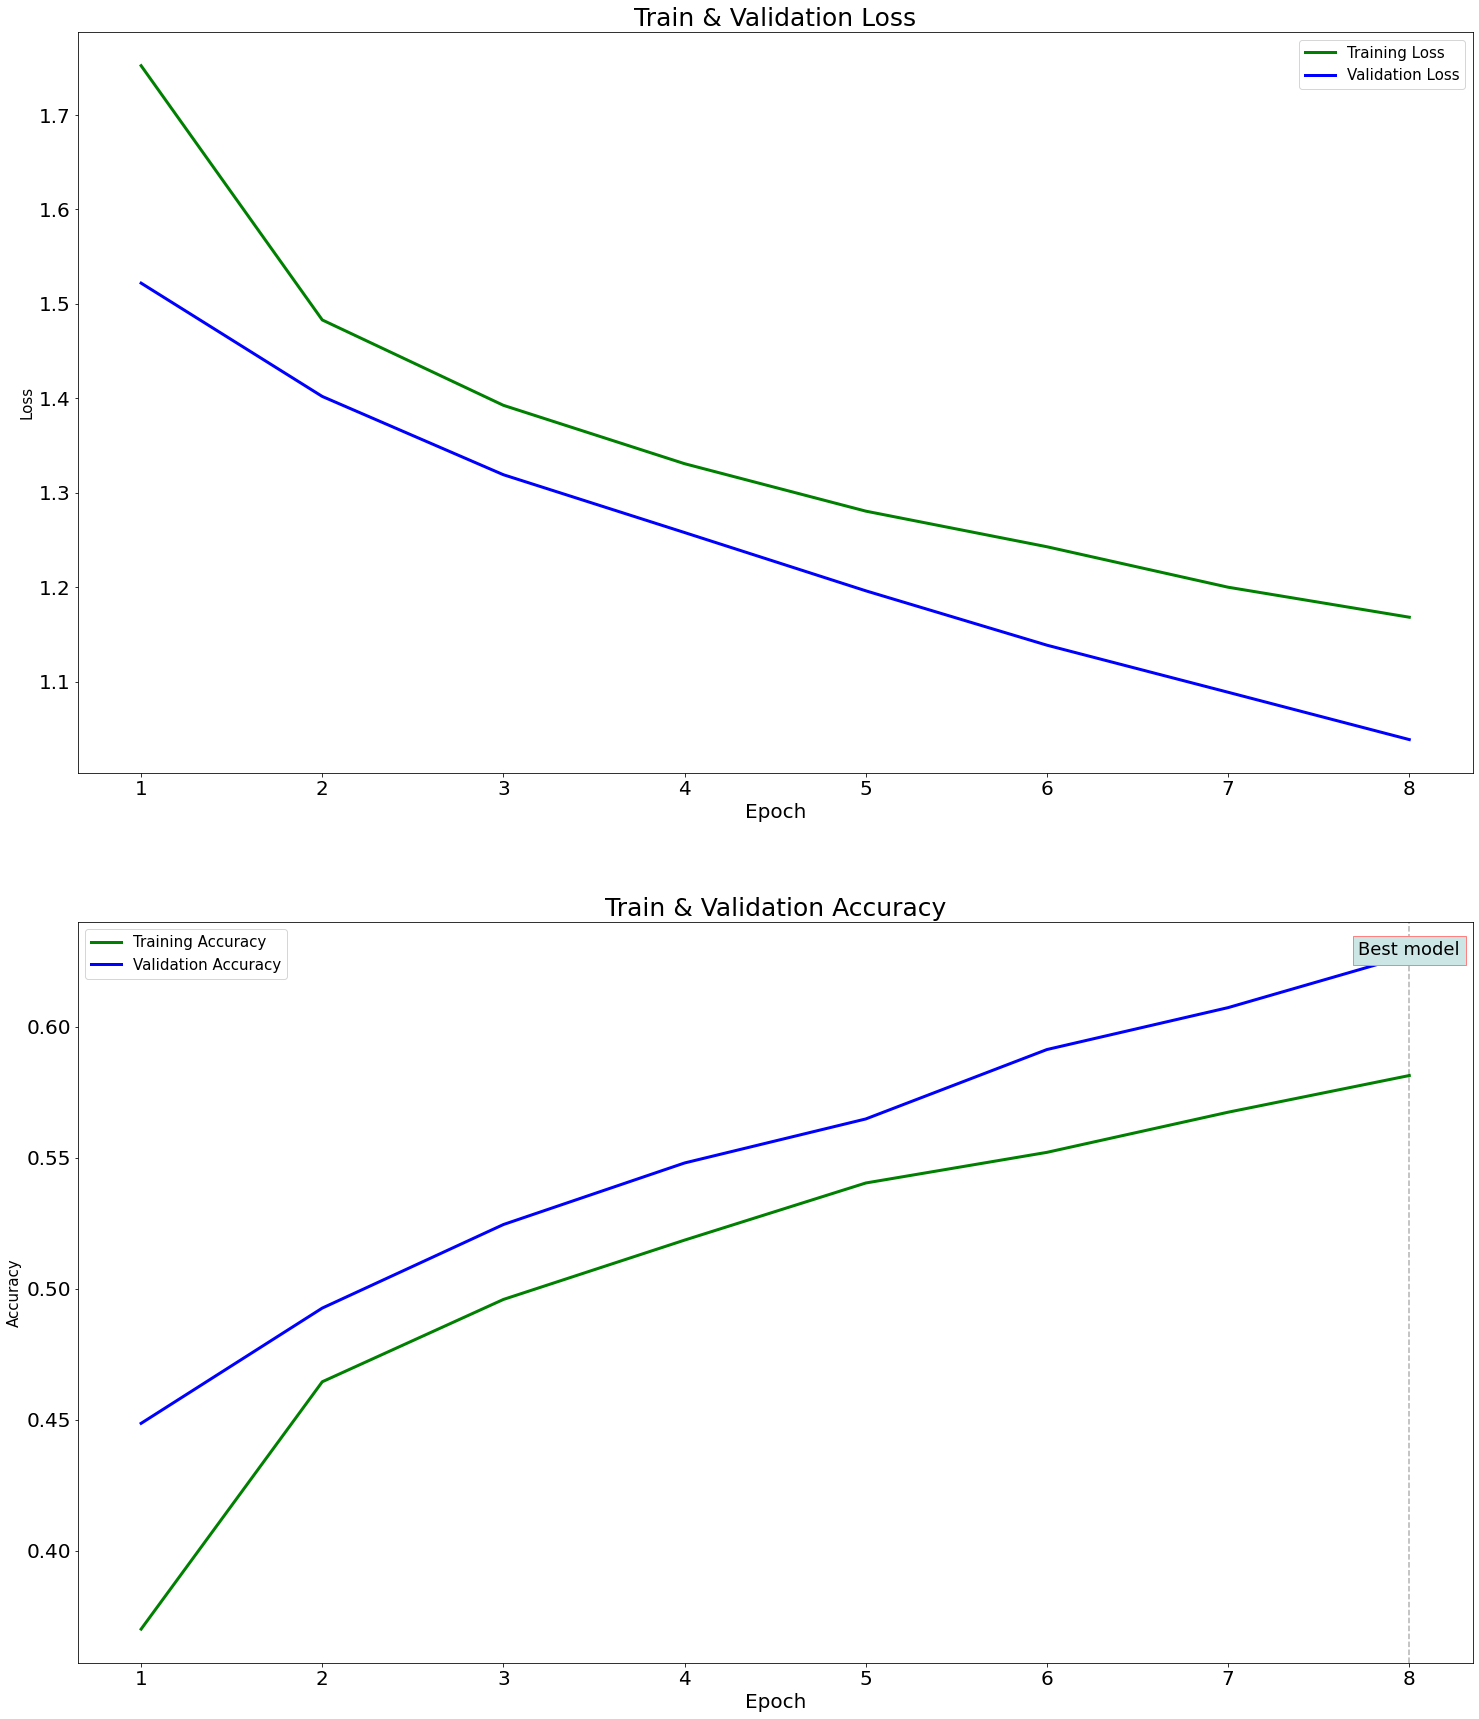

In [13]:
epochs = range(1,9)
fig, ax = plt.subplots(2,1, figsize=(25, 30))

ax[0].set_xlabel('Epoch',fontsize="20")
ax[0].tick_params(labelsize=20)
ax[0].set_ylabel('Loss', fontsize="15")
ax[0].set_title('Train & Validation Loss',fontsize="25")
ax[0].plot(epochs, train_loss, 'g', linewidth=3, label='Training Loss')
ax[0].plot(epochs, val_loss, 'b', linewidth=3, label='Validation Loss')
ax[0].legend(fontsize="15")


ax[1].set_xlabel('Epoch',fontsize="20")
ax[1].tick_params(labelsize=20)
ax[1].set_ylabel('Accuracy', fontsize="15")
ax[1].set_title('Train & Validation Accuracy',fontsize="25")
ax[1].plot(epochs, train_acc, 'g', linewidth=3, label='Training Accuracy')
ax[1].plot(epochs, val_acc, 'b', linewidth=3, label='Validation Accuracy')
ax[1].axvline(best_epoch, color='k', linestyle='--', alpha=0.3)
ax[1].text(best_epoch,val_acc[best_epoch-1],'Best model',fontsize=18,horizontalalignment='center',
        bbox=dict(boxstyle="square",
                   ec=(1., 0.5, 0.5),
                   fc=(0.8, 0.9, 0.9),))
ax[1].legend(fontsize="15")

plt.show()

# Evaluation

We will calculate the accuracy of the final model on the test set.

In [14]:
best_model.eval()               # Set model to evaluate mode
running_corrects = 0            # number of correct predictions
for sample in testloader:
    inputs = sample[0]
    labels = sample[1]
    inputs = inputs.to(device)
    labels = labels.to(device)
    class_prob = best_model.forward(inputs)                         # forward calc
    _ , predicted = torch.max(class_prob.data, 1)                   # batch prediction   
    running_corrects += torch.sum(predicted == labels)              # accumulate correct class preds
acc = running_corrects.double() / len(test_dataset)
print('Accuracy of best model on test set is: {:.2f}%'.format(acc*100))

Accuracy of best model on test set is: 56.78%


# Clarification Questions

**Explain the importance of the positional embedding in the ViT model.**

Positional embedding is crucial when implementing a Vision Transformer in order to give context to positional orientation of the segmented image. Esentially we break down the image into "words" (patches) wich are plugged into the transformer, not providing positional embeding would lead to positional information loss of the patches, making the self attention unable to understand the context between the patches. just like the position of a word in a sentance is crucial, the same apllies to patches of an image. Take for example an image of a celebrity's face, the model might be able to classify thats it's a face (by detecting individual elements such as eyes, nose, chin etc.) but it would be problematic to classify who the face belongs to.

**How would you evaluate the model if the number of samples per class would not be balanced?
How can you deal with class imbalance on multiclass classification?**

We would need to use a metric that takes this into consideration, for example F1 score that includes recall as one of its parameters. To deal with class imbalance we could use oversampling on the existing minority class, augmenting existing samples (brightnes, horizontal flip, etc.) or sythentic data generation.